In [1]:
import pandas as pd
from pathlib import Path
from labbench import stopwatch
from importlib import reload
import seamf, ziparchive
ziparchive = reload(ziparchive)
from ziparchive import read_seamf_zipfile, MultiProcessingZipFile, concat_dicts

from matplotlib.ticker import EngFormatter
from matplotlib.dates import DateFormatter
from matplotlib import rc
import itertools

def transposed_legend(ax, *args, **kws):
    def flip(items, ncol):
        return itertools.chain(*[items[i::ncol] for i in range(ncol)])

    ncol = kws.get('ncol',1)
    handles, labels = ax.get_legend_handles_labels()
    if len(args) > 0:
        handles = args[0]
        args = args[1:]
    if len(args) > 0:
        labels = args[1]
        args = args[1:]

    if ncol > 1:
        handles = flip(handles, ncol)
        labels = flip(labels, ncol)

    return ax.legend(handles, labels, *args, **kws)

rc('font',**{'family':'serif','serif':['Times New Roman']})

def nearest_datetimes(df, targets):
    return df.index[df.index.get_indexer(
        list(targets),
        method='nearest'
    )]


data_path = Path('data')/'NIT-2022-12-13.zip'

### Multiprocessing aggregation (dask.dataframe)
This is shown aggregating a single trace type (pfp) since it loads a single dataframe.

In [2]:
import dask
import dask.array
ziparchive = reload(ziparchive)
from ziparchive import read_seamf_zipfile, MultiProcessingZipFile, concat_dicts
import numpy as np
from dask import dataframe

@dask.delayed
def select(data: dict, key: str, stub) -> pd.DataFrame:
    if data is None:
        return stub
    
    return data[key]

def zipfile_delayed(data_path, limit_count: int=None, partition_size=40) -> dask.delayed:
    zfile = MultiProcessingZipFile(data_path)
    filelist = [n for n in zfile.namelist() if n.endswith('.sigmf')][:limit_count]
    file_blocks = np.split(filelist, range(0,len(filelist), partition_size))

    @dask.delayed
    def read_partition(files):
        return read_seamf_zipfile(zfile, allowlist=files)

    stubs = []

    first = read_seamf_zipfile(zfile, allowlist=filelist[:1])
    stubs.append({k: first[k].iloc[:0] for k in first.keys() if isinstance(first[k], pd.DataFrame)})

    last = read_seamf_zipfile(zfile, allowlist=filelist[-1:])
    stubs.append({k: last[k].iloc[0:] for k in last.keys() if isinstance(last[k], pd.DataFrame)})

    return [read_partition(block) for block in file_blocks], stubs

def zipfile_dask_dfs(data_path, limit_count: int=None, partition_size=40) -> dask.dataframe.DataFrame:
    dicts, (first, last) = zipfile_delayed(data_path, limit_count=limit_count, partition_size=partition_size)
    ddfs = {}

    for key in ('psd', 'pfp', 'pvt', 'sweep_metadata', 'channel_metadata'):
        ddfs[key] = dataframe.from_delayed(
            [select(d, key, first[key]) for d in dicts if d is not None],
            meta=first[key]
        )

    return ddfs

partition_size = 150

with stopwatch():
    ddfs = zipfile_dask_dfs(data_path, limit_count=None, partition_size=partition_size)
    dfs, = dask.compute(ddfs, scheduler='processes')

    # day, = dask.compute(
    #     {
    #         k: ddfs[k].loc['2022-12-13']
    #         for k in ('psd', 'pfp', 'pvt')
    #     },
    #     scheduler='processes'
    # )

 INFO   2023-02-21 16:28:45.832 • labbench: 326.805 s elapsed


In [3]:
import pickle
day = {
    k: dfs[k].loc['2022-11-01']
    for k in ('psd', 'pfp', 'pvt', 'channel_metadata')
}

with open('data/2022-11-01.p', 'wb') as fd:
    pickle.dump(day, fd)

<AxesSubplot:xlabel='datetime', ylabel='Channel power (dBm/10 MHz)'>

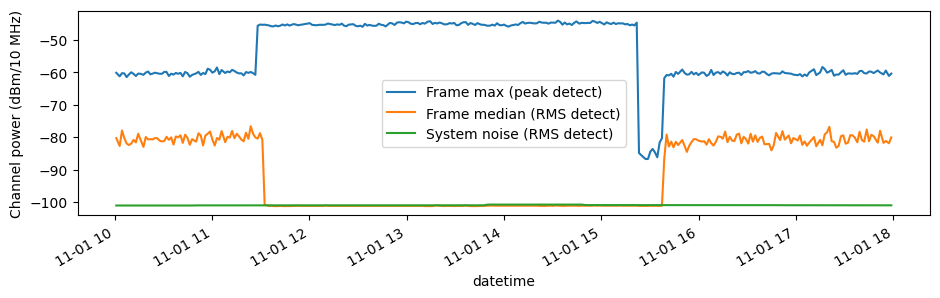

In [4]:
import matplotlib.pyplot as plt

def trace(dfs: dict, type: str, *columns: str, **inds):
    """ indexing shortcut for SEA data tables.

    Args:
        type: table name key (e.g., 'pfp', 'psd', 'channel_metadata', etc.)
        columns: if specified, the sequence of columns to select (otherwise all)
        inds: the index value to select, keyed on the label name
    """
    ret = dfs[type]

    if len(inds) > 0:
        ret = ret.xs(
            key=tuple(inds.values()),
            level=tuple(inds.keys()),
            drop_level=True
        )

    if len(columns) > 1:
        ret = ret[list(columns)]
    if len(columns) == 1:
        # this is actually a bit dicey, as it forces returning a series..
        # you might deliberately want to pass in a length-1 list to force
        # dataframe
        ret = ret[columns[0]]

    return ret

freq = 3605e6

pfp_indicators = {
    'Frame max (peak detect)': trace(day, 'pfp', frequency=freq, capture_statistic='max', detector='peak').max(axis=1),
    'Frame median (RMS detect)': trace(day, 'pfp', frequency=freq, capture_statistic='mean', detector='rms').quantile(0.5, axis=1),
    'System noise (RMS detect)': trace(day, 'channel_metadata', 'cal_noise_figure_dB', frequency=freq) + -174 + 70 - 1
}

pfp_indicators = pd.concat(pfp_indicators, axis=1)

fig, ax = plt.subplots(figsize=(11,3))
(
    pfp_indicators.loc['2022-11-01 10:00:00':'2022-11-01 18:00:00']
    .plot(ax=ax, ylabel='Channel power (dBm/10 MHz)')
)

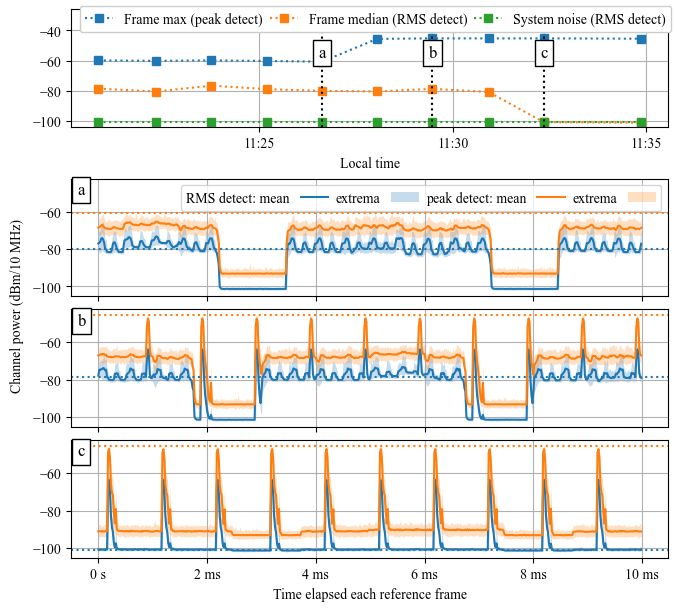

In [5]:
detail_trace_targets = {'a': '2022-11-01 11:26', 'b': '2022-11-01 11:30', 'c': '2022-11-01 11:33'}
mid_span = slice('2022-11-01 11:20:00','2022-11-01 11:35:00')

detail_label_style = dict(fontdict={'size': 12}, bbox=dict(boxstyle='square', facecolor='white'), color='black')

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k,v in detail_trace_targets.items()
}

fig, axs = plt.subplots(nrows=len(detail_datetimes)+1, figsize=(6 + 2/3, 6), layout='constrained')

# mid-scale view
(
    pfp_indicators.loc[mid_span]
    .plot(ax=axs[0], marker='s', ls=':', legend=False)
)
for label, index in detail_datetimes.items():
    axs[0].axvline(index, ls=':', color='k')
    axs[0].text(index, -55, label, va='center', ha='center', **detail_label_style)
axs[0].xaxis.set_major_formatter(DateFormatter('%H:%M'))
axs[0].set_xlabel('Local time')
axs[0].set_ylim([None, pfp_indicators['Frame max (peak detect)'].max()+18])
axs[0].grid(True)
fig.legend(ncol=3,columnspacing=0.5, loc='upper right', framealpha=1)
for t in axs[0].xaxis.get_ticklabels():
    t.set_rotation(0)
    t.set_horizontalalignment('center')


# detail view
for (label, datetime), ax in zip(detail_datetimes.items(), axs[1:]):
    # remaining index levels will be ('capture_statistic', 'detector')
    pfp_traces = trace(dfs=day, type='pfp', datetime=datetime, frequency=freq)
    ax.text(0.01, 0.97, label, ha='left', va='top', transform=ax.transAxes, **detail_label_style)

    for detector, color in dict(RMS='C0', peak='C1').items():
        (
            pfp_traces
            .loc['mean',detector.lower()]
            .plot(color=color, ax=ax, label=f'{detector} detect: mean')
        )

        ax.fill_between(
            pfp_traces.columns,
            pfp_traces.loc['min', detector.lower()],
            pfp_traces.loc['max', detector.lower()],
            color=color,
            alpha=0.25,
            lw=0,
            label=f'extrema',
            rasterized=True
        )

    pfp_ind = (
        pfp_indicators
        .loc[datetime]
        .loc[['Frame median (RMS detect)','Frame max (peak detect)']]
    )

    for power, color in zip(pfp_ind, ['C0', 'C1']):
        ax.axhline(power, color=color, ls=':')

    # ax.set_xlim([0,10.3e-3])

    ax.get_shared_x_axes().join(*axs[-len(detail_datetimes):])
    ax.get_shared_y_axes().join(*axs[-len(detail_datetimes):])
    ax.grid(True)

    if label == list(detail_trace_targets.keys())[0]:
        transposed_legend(ax, markerfirst=False, columnspacing=0.5, ncol=4, loc='upper right')

ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
ax.set_xlabel('Time elapsed each reference frame')
fig.supylabel('Channel power (dBm/10 MHz)', fontsize=10)

plt.savefig('nit_event_2022-11_pfp_start.svg')

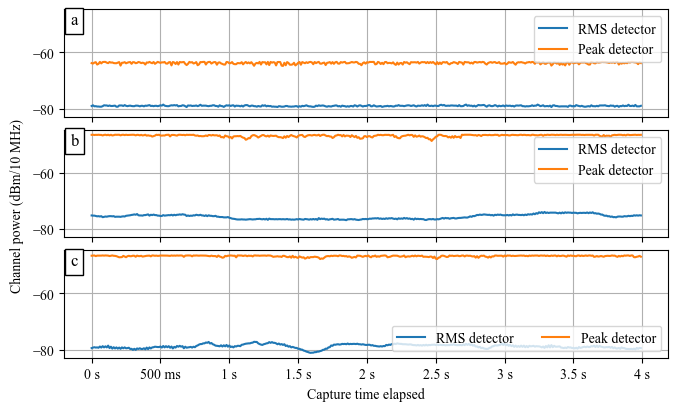

In [6]:
fig, axs = plt.subplots(nrows=len(detail_datetimes), figsize=(6 + 2/3, 4), layout='constrained', sharey=True)

detail_label_style = dict(fontdict={'size': 12}, bbox=dict(boxstyle='square', facecolor='white'), color='black')

# detail view
for (label, datetime), ax in zip(detail_datetimes.items(), axs[0:]):
    # remaining index levels will be ('capture_statistic', 'detector')
    pvt_traces = trace(dfs=day, type='pvt', datetime=datetime, frequency=freq)
    ax.text(0.01, 0.97, label, ha='left', va='top', transform=ax.transAxes, **detail_label_style)

    pvt_traces.T.iloc[:,::-1].plot(ax=ax, legend=False)
    ax.legend(['RMS detector', 'Peak detector'])    

    ax.get_shared_x_axes().join(*axs[-len(detail_datetimes):])
    ax.grid(True)

    # if label == list(detail_trace_targets.keys())[0]:
    #     transposed_legend(ax, markerfirst=False, columnspacing=0.5, ncol=4, loc='upper right')

ax.legend(['RMS detector', 'Peak detector'], loc='lower right', ncol=2)
ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
ax.set_xlabel('Capture time elapsed')
fig.supylabel('Channel power (dBm/10 MHz)', fontsize=10)

plt.savefig('nit_event_2022-11_pvt_start.svg')

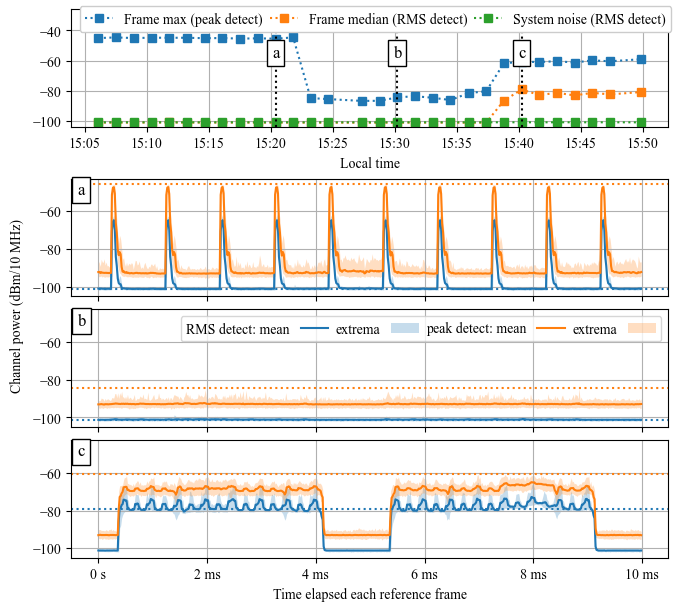

In [7]:
from matplotlib.ticker import EngFormatter

detail_trace_targets = {'a': '2022-11-01 15:20', 'b': '2022-11-01 15:30', 'c': '2022-11-01 15:40'}
mid_span = slice('2022-11-01 15:05:00','2022-11-01 15:50:00')

detail_label_style = dict(fontdict={'size': 12}, bbox=dict(boxstyle='square', facecolor='white'), color='black')

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k,v in detail_trace_targets.items()
}

fig, axs = plt.subplots(nrows=len(detail_datetimes)+1, figsize=(6 + 2/3, 6), layout='constrained')

# mid-scale view
(
    pfp_indicators.loc[mid_span]
    .plot(ax=axs[0], marker='s', ls=':', legend=False)
)
for label, index in detail_datetimes.items():
    axs[0].axvline(index, ls=':', color='k')
    axs[0].text(index, -55, label, va='center', ha='center', **detail_label_style)
axs[0].xaxis.set_major_formatter(DateFormatter('%H:%M'))
axs[0].set_xlabel('Local time')
axs[0].set_ylim([None, pfp_indicators['Frame max (peak detect)'].max()+18])
axs[0].grid(True)
fig.legend(ncol=3,columnspacing=0.5, loc='upper right', framealpha=1)
for t in axs[0].xaxis.get_ticklabels():
    t.set_rotation(0)
    t.set_horizontalalignment('center')


# detail view
for (label, datetime), ax in zip(detail_datetimes.items(), axs[1:]):
    # remaining index levels will be ('capture_statistic', 'detector')
    pfp_traces = trace(dfs=day, type='pfp', datetime=datetime, frequency=freq)
    ax.text(0.01, 0.97, label, ha='left', va='top', transform=ax.transAxes, **detail_label_style)

    for detector, color in dict(RMS='C0', peak='C1').items():
        (
            pfp_traces
            .loc['mean',detector.lower()]
            .plot(color=color, ax=ax, label=f'{detector} detect: mean')
        )

        ax.fill_between(
            pfp_traces.columns,
            pfp_traces.loc['min', detector.lower()],
            pfp_traces.loc['max', detector.lower()],
            color=color,
            alpha=0.25,
            lw=0,
            label=f'extrema',
            rasterized=True
        )

    pfp_ind = (
        pfp_indicators
        .loc[datetime]
        .loc[['Frame median (RMS detect)','Frame max (peak detect)']]
    )

    for power, color in zip(pfp_ind, ['C0', 'C1']):
        ax.axhline(power, color=color, ls=':')

    # ax.set_xlim([0,10.3e-3])

    ax.get_shared_x_axes().join(*axs[-len(detail_datetimes):])
    ax.get_shared_y_axes().join(*axs[-len(detail_datetimes):])
    ax.grid(True)

    if label == list(detail_trace_targets.keys())[1]:
        transposed_legend(ax, markerfirst=False, columnspacing=0.5, ncol=4, loc='upper right')

ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
ax.set_xlabel('Time elapsed each reference frame')
fig.supylabel('Channel power (dBm/10 MHz)', fontsize=10)

plt.savefig('nit_event_2022-11_pfp_end.svg')

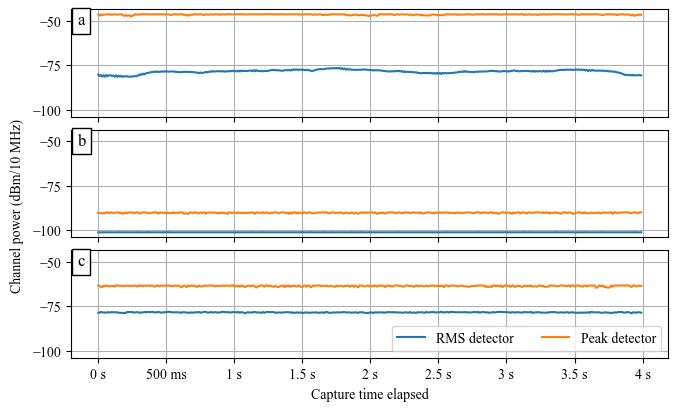

In [8]:
fig, axs = plt.subplots(nrows=len(detail_datetimes), figsize=(6 + 2/3, 4), layout='constrained', sharey=True)

detail_label_style = dict(fontdict={'size': 12}, bbox=dict(boxstyle='square', facecolor='white'), color='black')

# detail view
for (label, datetime), ax in zip(detail_datetimes.items(), axs[0:]):
    # remaining index levels will be ('capture_statistic', 'detector')
    pvt_traces = trace(dfs=day, type='pvt', datetime=datetime, frequency=freq)
    ax.text(0.01, 0.97, label, ha='left', va='top', transform=ax.transAxes, **detail_label_style)

    pvt_traces.T.iloc[:,::-1].plot(ax=ax, legend=False)

    ax.get_shared_x_axes().join(*axs[-len(detail_datetimes):])
    ax.grid(True)

    # if label == list(detail_trace_targets.keys())[0]:
    #     transposed_legend(ax, markerfirst=False, columnspacing=0.5, ncol=4, loc='upper right')

ax.legend(['RMS detector', 'Peak detector'], loc='lower right', ncol=2)
ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
ax.set_xlabel('Capture time elapsed')
fig.supylabel('Channel power (dBm/10 MHz)', fontsize=10)

plt.savefig('nit_event_2022-11_pvt_end.svg')